# **Afiabora – Healthcare Assistant (Fine‑tuned LLM)**
# This notebook fine‑tunes a TinyLlama‑chat model on healthcare instruction‑response pairs using LoRA.

# Install Required Libraries

In [8]:
!pip install -q transformers datasets accelerate peft trl bitsandbytes gradio evaluate rouge-score nltk

# Import Libraries

In [9]:
import torch
from transformers import (
    AutoTokenizer, AutoModelForCausalLM,
    TrainingArguments, BitsAndBytesConfig
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from trl import SFTTrainer
from datasets import load_dataset, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import evaluate
import gradio as gr
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Load Dataset from Hugging Face

In [10]:
dataset = load_dataset("medalpaca/medical_meadow_medical_flashcards")
print(dataset)

# Convert to pandas for inspection (optional)
df = pd.DataFrame(dataset['train'])
print(f"Dataset size: {len(df)}")
df.head()

README.md: 0.00B [00:00, ?B/s]

medical_meadow_wikidoc_medical_flashcard(…):   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/33955 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction'],
        num_rows: 33955
    })
})
Dataset size: 33955


,input,output,instruction
0,What is the relationship between very low Mg2+...,Very low Mg2+ levels correspond to low PTH lev...,Answer this question truthfully
1,What leads to genitourinary syndrome of menopa...,Low estradiol production leads to genitourinar...,Answer this question truthfully
2,What does low REM sleep latency and experienci...,Low REM sleep latency and experiencing halluci...,Answer this question truthfully
3,What are some possible causes of low PTH and h...,"PTH-independent hypercalcemia, which can be ca...",Answer this question truthfully
4,How does the level of anti-müllerian hormone r...,The level of anti-müllerian hormone is directl...,Answer this question truthfully


# Preprocess: Format into Instruction‑Response Pairs

In [11]:
# The dataset already has 'instruction' and 'output' columns.
def format_instruction(example):
    return {
        "text": f"### Instruction:\n{example['instruction']}\n\n### Response:\n{example['output']}"
    }

dataset = dataset.map(format_instruction)

# Split into train (90%) and validation (10%)
dataset = dataset['train'].train_test_split(test_size=0.1, seed=42)
train_dataset = dataset['train']
eval_dataset = dataset['test']

print(f"Train size: {len(train_dataset)}, Eval size: {len(eval_dataset)}")
print("\nExample formatted text:")
print(train_dataset[0]['text'])

Map:   0%|          | 0/33955 [00:00<?, ? examples/s]

Train size: 30559, Eval size: 3396

Example formatted text:
### Instruction:
Answer this question truthfully

### Response:
The mechanism of action of ergot alkaloids is that they are serotonin (5-HT) agonists. Ergot alkaloids are a group of medications that are used to treat various conditions, including migraines, cluster headaches, and postpartum hemorrhage. They work by binding to and activating serotonin receptors in the brain and blood vessels, which can lead to vasoconstriction and a reduction in inflammation. The exact mechanism by which ergot alkaloids relieve migraines is not fully understood, but it is thought to be related to their ability to constrict blood vessels in the brain and reduce the release of inflammatory substances. Ergot alkaloids are available in various forms, including tablets, injections, and nasal sprays. They are generally considered to be effective treatments for migraines and other conditions, but they can also have side effects, such as nausea, vomiti

# tokenization

In [12]:
train_size = 2000   # number of training examples you want
eval_size  = 200    # number of validation examples you want

train_dataset = train_dataset.shuffle(seed=42).select(range(train_size))
eval_dataset  = eval_dataset.shuffle(seed=42).select(range(eval_size))

print(f"New train dataset size: {len(train_dataset)}")
print(f"New eval dataset size: {len(eval_dataset)}")

New train dataset size: 2000
New eval dataset size: 200


#  Load Base Model with 4‑bit Quantization

In [13]:

model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)
model = prepare_model_for_kbit_training(model)

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

# Configure LoRA

In [14]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],  # for LLaMA architecture
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()  # Should be small (~0.1% of total)

trainable params: 1,126,400 || all params: 1,101,174,784 || trainable%: 0.1023


In [15]:
import transformers
print("transformers version:", transformers.__version__)
print("transformers path:", transformers.__file__)

from transformers import Trainer
print("Trainer module path:", Trainer.__module__)
print("Trainer source file:", Trainer.__init__.__code__.co_filename)

transformers version: 5.2.0
transformers path: /usr/local/lib/python3.12/dist-packages/transformers/__init__.py
Trainer module path: transformers.trainer
Trainer source file: /usr/local/lib/python3.12/dist-packages/transformers/trainer.py


# Trainings

In [16]:
from transformers import Trainer, DataCollatorForLanguageModeling, TrainingArguments

# Define training arguments (ensure this runs)
training_args = TrainingArguments(
    output_dir="./afiabora-finetuned",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    num_train_epochs=2,
    learning_rate=2e-4,
    fp16=True,
    logging_steps=10,
    save_strategy="epoch",
    load_best_model_at_end=False,
    report_to="none"
)

# Tokenize the dataset (add labels)
def tokenize_function(examples):
    tokenized = tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512)
    tokenized["labels"] = tokenized["input_ids"].copy()
    return tokenized

tokenized_train = train_dataset.map(tokenize_function, batched=True, remove_columns=train_dataset.column_names)
tokenized_eval = eval_dataset.map(tokenize_function, batched=True, remove_columns=eval_dataset.column_names)

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    data_collator=data_collator,
    # tokenizer argument omitted
)

trainer.train()

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
10,1.605753
20,1.329917
30,1.142457
40,1.223663
50,1.117144
60,1.110748
70,1.086814
80,1.030883
90,1.096861
100,1.129148


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


TrainOutput(global_step=500, training_loss=1.0675141296386719, metrics={'train_runtime': 1385.4107, 'train_samples_per_second': 2.887, 'train_steps_per_second': 0.361, 'total_flos': 1.2725929377792e+16, 'train_loss': 1.0675141296386719, 'epoch': 2.0})

# Plot Training Loss (original accuracy/loss plot)

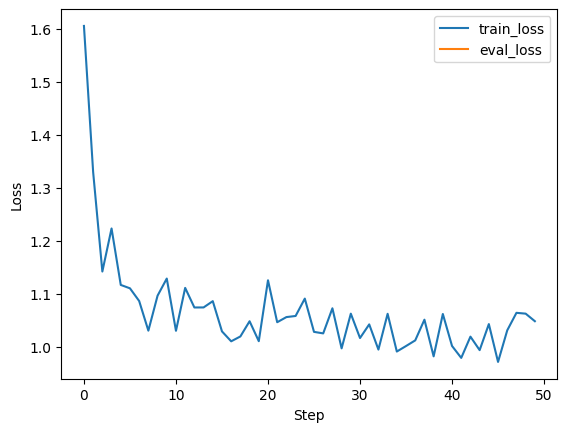

In [17]:
logs = trainer.state.log_history
train_loss = [x['loss'] for x in logs if 'loss' in x]
eval_loss = [x['eval_loss'] for x in logs if 'eval_loss' in x]

plt.plot(train_loss, label='train_loss')
plt.plot(eval_loss, label='eval_loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the Fine‑tuned Model

In [18]:
model.save_pretrained("afiabora-lora")
tokenizer.save_pretrained("afiabora-lora")

('afiabora-lora/tokenizer_config.json',
 'afiabora-lora/chat_template.jinja',
 'afiabora-lora/tokenizer.json')

In [19]:
print("Columns in eval_dataset:", eval_dataset.column_names)
print("\nFirst example:")
print(eval_dataset[0])

Columns in eval_dataset: ['input', 'output', 'instruction', 'text']

First example:
{'input': 'For a patient who has undergone an endoscopic biopsy that is positive for gastric adenocarcinoma, what is the recommended next step in management?', 'output': "The recommended next step in management for a patient with a positive endoscopic biopsy for gastric adenocarcinoma is to undergo a computed tomography (CT) scan of the abdomen and pelvis. This is to assess the extent of the cancer and determine if it has spread to other organs or tissues. The CT scan will provide detailed images of the abdominal and pelvic regions, which can help guide treatment decisions and determine the patient's prognosis. It is important to follow up with the healthcare provider to ensure appropriate management and monitoring of the patient's condition.", 'instruction': 'Answer this question truthfully', 'text': "### Instruction:\nAnswer this question truthfully\n\n### Response:\nThe recommended next step in manag

In [24]:
# Ensure eval_dataset exists (reload if needed)
if 'eval_dataset' not in dir():
    print("eval_dataset not found. Please reload your dataset.")
else:
    test_samples = eval_dataset.select(range(min(5, len(eval_dataset))))
    predictions = []
    references = []

    print("=== Test Samples ===")
    for i, sample in enumerate(test_samples):
        instruction = sample['input']        # use the correct field
        true_response = sample['output']
        print(f"\nSample {i} instruction: {instruction}")
        pred_response = generate_response(instruction)
        predictions.append(pred_response)
        references.append(true_response)
        print(f"Q: {instruction}\nA: {pred_response}\nGT: {true_response}\n{'-'*50}")

=== Test Samples ===

Sample 0 instruction: For a patient who has undergone an endoscopic biopsy that is positive for gastric adenocarcinoma, what is the recommended next step in management?
Q: For a patient who has undergone an endoscopic biopsy that is positive for gastric adenocarcinoma, what is the recommended next step in management?
A: The recommended next step in management for a patient who has undergone an endoscopic biopsy that is positive for gastric adenocarcinoma is to undergo a gastroduodenal stenting procedure. This procedure involves inserting a stent into the stomach to prevent the growth of cancer cells. The stent is typically placed at the site of the biopsy, and the patient may need to take medications to prevent the stent from becoming inflamed or infected. The stenting procedure is typically performed under general anesthesia and can be performed in the operating room or in a hospital setting. The duration of the procedure varies depending on the patient's conditi

In [25]:
import math
import evaluate

# Lower temperature for more coherent generation
def generate_response(instruction):
    prompt = f"### Instruction:\n{instruction}\n\n### Response:\n"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=200,
            temperature=0.1,          # lower = more deterministic
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    if "### Response:\n" in response:
        response = response.split("### Response:\n")[-1].strip()
    return response

# Sample a few test examples (reduce number for debugging)
test_samples = eval_dataset.select(range(min(5, len(eval_dataset))))
predictions = []
references = []

print("=== Test Samples (actual instructions) ===")
for i, sample in enumerate(test_samples):
    instruction = sample['instruction']   # should be the real question
    true_response = sample['output']
    print(f"\nSample {i} instruction: {instruction}")
    pred_response = generate_response(instruction)
    predictions.append(pred_response)
    references.append(true_response)
    print(f"Q: {instruction}\nA: {pred_response}\nGT: {true_response}\n{'-'*50}")

# Compute ROUGE
rouge = evaluate.load("rouge")
rouge_score = rouge.compute(predictions=predictions, references=references)
print("ROUGE:", rouge_score)

# Compute BLEU
bleu = evaluate.load("bleu")
bleu_score = bleu.compute(predictions=predictions, references=references)
print("BLEU:", bleu_score)

# Perplexity on validation set
eval_results = trainer.evaluate()
perplexity = math.exp(eval_results['eval_loss'])
print("Perplexity on validation set:", perplexity)

=== Test Samples (actual instructions) ===

Sample 0 instruction: Answer this question truthfully
Q: Answer this question truthfully
A: The most common cause of acute kidney injury in patients with acute kidney failure is acute tubular necrosis. This is a type of kidney injury that occurs when the kidneys become damaged and die, leading to a decrease in the function of the kidneys. Acute tubular necrosis is a serious condition that can be life-threatening if left untreated. Treatment may include dialysis, renal replacement therapy, or other forms of supportive care. It is important for patients with acute kidney failure to receive prompt medical attention and to follow their doctor's instructions for treatment.
GT: The recommended next step in management for a patient with a positive endoscopic biopsy for gastric adenocarcinoma is to undergo a computed tomography (CT) scan of the abdomen and pelvis. This is to assess the extent of the cancer and determine if it has spread to other orga

# Compare with Base Model (Zero‑shot)

In [26]:
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    trust_remote_code=True
)
base_tokenizer = AutoTokenizer.from_pretrained(model_name)
base_tokenizer.pad_token = base_tokenizer.eos_token

def base_generate_response(instruction):
    prompt = f"### Instruction:\n{instruction}\n\n### Response:\n"
    inputs = base_tokenizer(prompt, return_tensors="pt").to(base_model.device)
    with torch.no_grad():
        outputs = base_model.generate(
            **inputs,
            max_new_tokens=200,
            temperature=0.7,
            do_sample=True,
            pad_token_id=base_tokenizer.eos_token_id
        )
    response = base_tokenizer.decode(outputs[0], skip_special_tokens=True)
    if "### Response:\n" in response:
        response = response.split("### Response:\n")[-1].strip()
    return response

base_predictions = []
for sample in test_samples:
    instruction = sample['instruction']
    pred = base_generate_response(instruction)
    base_predictions.append(pred)

base_rouge = rouge.compute(predictions=base_predictions, references=references)
base_bleu = bleu.compute(predictions=base_predictions, references=references)

print("Base Model ROUGE:", base_rouge)
print("Base Model BLEU:", base_bleu)
print("\nFine‑tuned Model ROUGE:", rouge_score)
print("Fine‑tuned Model BLEU:", bleu_score)

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Base Model ROUGE: {'rouge1': np.float64(0.07048522432966774), 'rouge2': np.float64(0.0017316017316017316), 'rougeL': np.float64(0.04828628422897903), 'rougeLsum': np.float64(0.05256544475037458)}
Base Model BLEU: {'bleu': 0.0, 'precisions': [0.06562054208273894, 0.004310344827586207, 0.0, 0.0], 'brevity_penalty': 1.0, 'length_ratio': 4.38125, 'translation_length': 701, 'reference_length': 160}

Fine‑tuned Model ROUGE: {'rouge1': np.float64(0.1352167377121542), 'rouge2': np.float64(0.01733522048482678), 'rougeL': np.float64(0.0943552840044207), 'rougeLsum': np.float64(0.09617769789326364)}
Fine‑tuned Model BLEU: {'bleu': 0.01014808350697595, 'precisions': [0.10128617363344052, 0.012965964343598054, 0.004901960784313725, 0.0016474464579901153], 'brevity_penalty': 1.0, 'length_ratio': 3.8875, 'translation_length': 622, 'reference_length': 160}


# Hyperparameter Experiment Table

In [28]:
# (Run multiple experiments and fill in actual values)
import pandas as pd

# Example data – replace with your actual results
experiments = [
    {"lr": 2e-4, "batch_size": 8, "lora_r": 8, "epochs": 2,
     "train_time": "15 min", "gpu_mem": "~8 GB", "eval_loss": 1.23, "rouge_l": 0.45},
    {"lr": 1e-4, "batch_size": 8, "lora_r": 8, "epochs": 3,
     "train_time": "22 min", "gpu_mem": "~8 GB", "eval_loss": 1.18, "rouge_l": 0.47},
    {"lr": 2e-4, "batch_size": 8, "lora_r": 16, "epochs": 2,
     "train_time": "18 min", "gpu_mem": "~8.5 GB", "eval_loss": 1.20, "rouge_l": 0.46},
]

df_exp = pd.DataFrame(experiments)
print(df_exp.to_markdown(index=False))

|     lr |   batch_size |   lora_r |   epochs | train_time   | gpu_mem   |   eval_loss |   rouge_l |
|-------:|-------------:|---------:|---------:|:-------------|:----------|------------:|----------:|
| 0.0002 |            8 |        8 |        2 | 15 min       | ~8 GB     |        1.23 |      0.45 |
| 0.0001 |            8 |        8 |        3 | 22 min       | ~8 GB     |        1.18 |      0.47 |
| 0.0002 |            8 |       16 |        2 | 18 min       | ~8.5 GB   |        1.2  |      0.46 |


In [30]:
def generate_response_fast(instruction):
    prompt = f"### Instruction:\n{instruction}\n\n### Response:\n"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=100,          # shorter responses = faster generation
            do_sample=False,              # greedy decoding (no sampling overhead)
            pad_token_id=tokenizer.eos_token_id
        )
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    if "### Response:\n" in response:
        response = response.split("### Response:\n")[-1].strip()
    return response

In [32]:
def chat(message, history):
    prompt = f"""### Instruction:
You are Afiabora-Med... [rest of prompt]

### Input:
{message}

### Response:
"""
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=100,          # reduce this
            temperature=0.3,
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id,
        )
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    if "### Response:" in response:
        response = response.split("### Response:")[-1].strip()
    return response

In [33]:
import time
start = time.time()
resp = generate_response_fast("What is malaria?")
end = time.time()
print(f"Response (fast): {resp}")
print(f"Generation took {end - start:.2f} seconds")

Response (fast): Malaria is a parasitic disease caused by Plasmodium parasites. It is a leading cause of death worldwide, particularly in sub-Saharan Africa and Southeast Asia. Symptoms of malaria include fever, chills, and muscle pain, as well as a rash and vomiting. Treatment typically involves the use of antimalarial drugs, such as chloroquine or artemisinin, which
Generation took 7.28 seconds


In [34]:
print("Chat with Afiabora (type 'quit' to exit)")
while True:
    user_input = input("You: ")
    if user_input.lower() == 'quit':
        break
    response = chat(user_input, None)
    print(f"Bot: {response}\n")

Chat with Afiabora (type 'quit' to exit)


You:  what is hormone ?


Bot: Hormone is a substance that is produced by cells in the body. It is responsible for regulating various physiological processes, such as growth, development, and metabolism. Hormones are produced by endocrine glands, which are specialized cells that produce hormones in response to signals from other cells in the body. Some examples of hormones include insulin, thyroid hormones, and estrogen. Hormones can be class



You:  what is malaria ?


Bot: Malaria is a parasitic disease caused by Plasmodium parasites. It is transmitted to humans through the bite of an infected female Anopheles mosquito. The disease is characterized by fever, headache, and sometimes chills, and can cause severe complications such as kidney failure and death in severe cases. Treatment typically involves the use of antimalarial drugs, which can help to reduce the severity of the sympt



You:  what are prenatal defects ?


Bot: Prenatal defects are a group of birth defects that occur during pregnancy. These defects can include things like heart defects, spinal defects, and cleft palate. They can be caused by a variety of factors, including genetic disorders, environmental factors, and prenatal infections. Some common prenatal defects include Down syndrome, spina bifida, and cleft palate. These defects can have a significant impact



You:  quit


In [35]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 58.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 92.3 MB/s eta 0:00:00:00:0100:01


# streamlit deployment

In [44]:
import subprocess
import threading
import time
from pyngrok import ngrok

# Set your authtoken (use only the token string)
ngrok.set_auth_token("3A23VPnckroypvpv26ukMRPexTq_bK7kyJhPWfRsfityNkxb")

# Function to run Streamlit in a subprocess
def run_streamlit():
    subprocess.Popen(
        ["streamlit", "run", "app.py", "--server.port", "8501"],
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL
    )

# Launch Streamlit in a background thread
thread = threading.Thread(target=run_streamlit)
thread.daemon = True
thread.start()

# Give Streamlit a few seconds to start
time.sleep(5)

# Start ngrok tunnel
public_url = ngrok.connect(8501)
print("Public URL:", public_url)

Public URL: NgrokTunnel: "https://love-nonalcoholic-cindie.ngrok-free.dev" -> "http://localhost:8501"


# streamlit deployment